### Настройка окружения

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Подгрузка датасета

In [2]:
import os
import torch.utils.data as data
from SignDataset import SignDataset

basedir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print('Basedir:  ' + basedir)
dataset_dir = os.path.join(basedir, 'dataset')
weights_dir = os.path.join(os.getcwd(), 'weights')


train_dataset = SignDataset(os.path.join(dataset_dir, 'sign_mnist_train.csv'))
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
print(f'Training dataset length: {len(train_dataset)}')

test_batch_size = 500
test_dataset = SignDataset(os.path.join(dataset_dir, 'sign_mnist_test.csv'))
test_loader = data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print(f'Test dataset length:     {len(test_dataset)}')

Basedir:  d:\WorkSpace\GitHub\DS\sign-language-mnist
Training dataset length: 27455
Test dataset length:     7172


### Модель 1: Классический персептрон

#### Обучение

Epoch [1/15] CrossEntropy: 2.612, Accuracy: 0.251: 100%|██████████| 215/215 [00:04<00:00, 49.18it/s]
Epoch [2/15] CrossEntropy: 1.758, Accuracy: 0.498: 100%|██████████| 215/215 [00:04<00:00, 53.06it/s]
Epoch [3/15] CrossEntropy: 1.391, Accuracy: 0.605: 100%|██████████| 215/215 [00:04<00:00, 46.90it/s]
Epoch [4/15] CrossEntropy: 1.173, Accuracy: 0.663: 100%|██████████| 215/215 [00:04<00:00, 45.36it/s]
Epoch [5/15] CrossEntropy: 1.023, Accuracy: 0.711: 100%|██████████| 215/215 [00:04<00:00, 44.06it/s]
Epoch [6/15] CrossEntropy: 0.907, Accuracy: 0.746: 100%|██████████| 215/215 [00:04<00:00, 49.96it/s]
Epoch [7/15] CrossEntropy: 0.814, Accuracy: 0.775: 100%|██████████| 215/215 [00:04<00:00, 50.63it/s]
Epoch [8/15] CrossEntropy: 0.734, Accuracy: 0.801: 100%|██████████| 215/215 [00:04<00:00, 50.12it/s]
Epoch [9/15] CrossEntropy: 0.673, Accuracy: 0.819: 100%|██████████| 215/215 [00:04<00:00, 48.56it/s]
Epoch [10/15] CrossEntropy: 0.617, Accuracy: 0.837: 100%|██████████| 215/215 [00:04<00:00, 

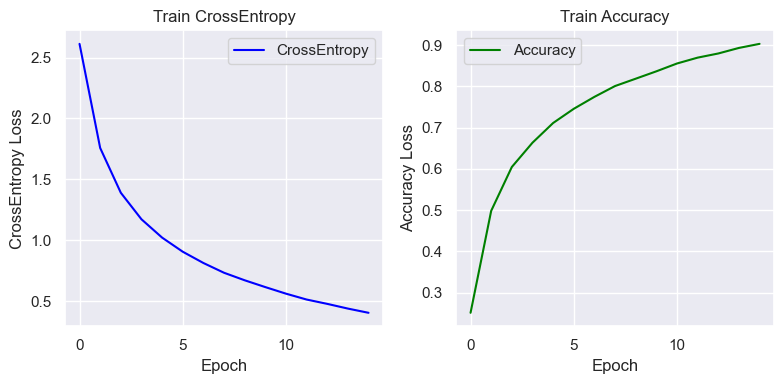

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from tqdm import tqdm
from SignPerceptronClassifier import SignPerceptronClassifier

model = SignPerceptronClassifier(28**2, 128, 25).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

epochs = 15
model.train()

cross_entropy_values = []
accuracy_values = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_title('Train CrossEntropy')
ax2.set_title('Train Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('CrossEntropy Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy Loss')

for epoch in range(epochs):
    cross_en_avg = 0
    accuracy_avg = 0
    batch_count = 0
    
    train_progress = tqdm(train_loader, leave=True)
    for inputs, targets in train_progress:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
        
        _, predicted_classes = torch.max(predictions, 1)
        correct_predictions = (predicted_classes == targets).sum().item()
        accuracy = correct_predictions / targets.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_count += 1
        cross_en_avg = (1 / batch_count) * loss.item() + (1 - 1 / batch_count) * cross_en_avg
        accuracy_avg = (1 / batch_count) * accuracy + (1 - 1 / batch_count) * accuracy_avg
        
        train_progress.set_description(f'Epoch [{epoch + 1}/{epochs}] ' + \
            f'CrossEntropy: {cross_en_avg:.3f}, Accuracy: {accuracy_avg:.3f}')
    
    cross_entropy_values.append(cross_en_avg)
    accuracy_values.append(accuracy_avg)

torch.save(model.state_dict(), os.path.join(weights_dir, 'sign_perceptron_weights.pth'))

ax1.plot(range(epochs), cross_entropy_values, color='blue', label='CrossEntropy')
ax2.plot(range(epochs), accuracy_values, color='green', label='Accuracy')
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()


#### Тестирование модели 1: Классический персептрон

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import string

correct_predictions = 0
total_test_loss = 0

model.eval()

sample_images = []
sample_probs = []

# For visualization
random_indices = np.random.choice(test_batch_size, 2, replace=False)

for i, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
        total_test_loss += loss.item()
        predicted_classes = torch.argmax(predictions, dim=1)
        correct_predictions += torch.sum(predicted_classes == targets).item()
        
        if len(sample_images) < 2:
            for idx in random_indices:
                if i * len(inputs) + idx < len(test_dataset):
                    sample_images.append(inputs[idx].cpu().numpy())
                    sample_probs.append(torch.softmax(predictions[idx], dim=0).cpu().numpy())

accuracy = correct_predictions / len(test_dataset)
average_test_loss = total_test_loss / len(test_loader)

print(f'Test CrossEntropy Loss: {average_test_loss:.3f}')
print(f'Test Accuracy: {accuracy:.3f}')

Test CrossEntropy Loss: 1.047
Test Accuracy: 0.689


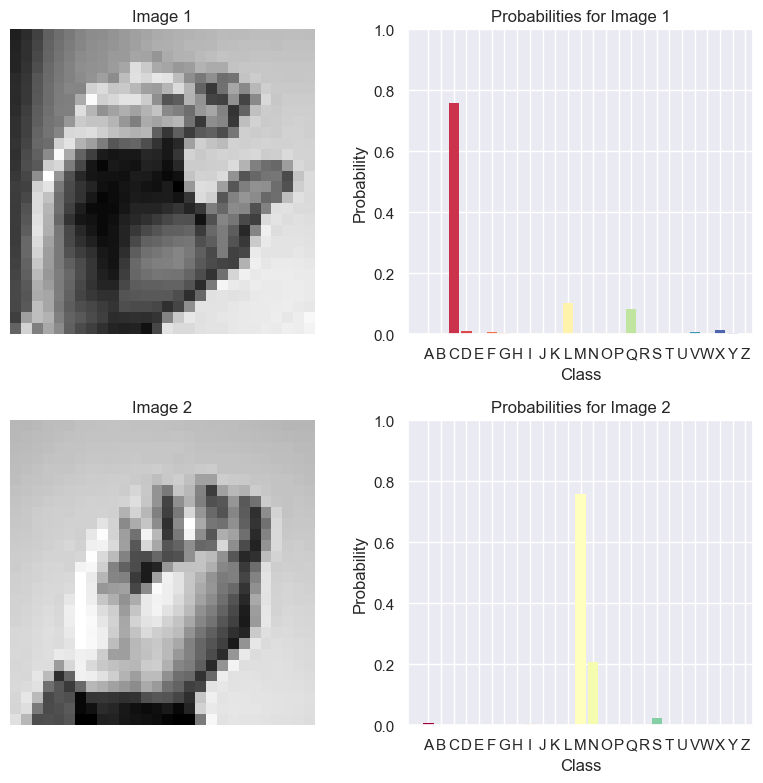

In [5]:
class_labels = list(string.ascii_uppercase)[:26]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
cmap = plt.get_cmap("Spectral")

for i in range(2):
    ax = axes[i, 0]
    ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Image {i+1}')
    ax = axes[i, 1]
    
    bars = ax.bar(range(25), sample_probs[i], color=cmap(np.linspace(0, 1, 25)), edgecolor='none')
    
    ax.set_ylim(0, 1)
    ax.set_title(f'Probabilities for Image {i+1}')
    ax.set_xticks(range(26))
    ax.set_xticklabels(class_labels)
    ax.set_xlabel('Class')
    ax.set_ylabel('Probability')

plt.tight_layout()
plt.show()


### Модель 2: Сверточная нейросеть

#### Обучение

Epoch [1/10] CrossEntropy: 1.886, Accuracy: 0.438: 100%|██████████| 215/215 [00:10<00:00, 20.93it/s]
Epoch [2/10] CrossEntropy: 0.432, Accuracy: 0.868: 100%|██████████| 215/215 [00:06<00:00, 34.39it/s]
Epoch [3/10] CrossEntropy: 0.159, Accuracy: 0.958: 100%|██████████| 215/215 [00:05<00:00, 36.68it/s]
Epoch [4/10] CrossEntropy: 0.057, Accuracy: 0.991: 100%|██████████| 215/215 [00:05<00:00, 37.24it/s]
Epoch [5/10] CrossEntropy: 0.026, Accuracy: 0.997: 100%|██████████| 215/215 [00:05<00:00, 35.95it/s]
Epoch [6/10] CrossEntropy: 0.011, Accuracy: 0.999: 100%|██████████| 215/215 [00:07<00:00, 30.42it/s]
Epoch [7/10] CrossEntropy: 0.006, Accuracy: 1.000: 100%|██████████| 215/215 [00:05<00:00, 36.96it/s]
Epoch [8/10] CrossEntropy: 0.005, Accuracy: 1.000: 100%|██████████| 215/215 [00:05<00:00, 38.53it/s]
Epoch [9/10] CrossEntropy: 0.003, Accuracy: 1.000: 100%|██████████| 215/215 [00:05<00:00, 39.39it/s]
Epoch [10/10] CrossEntropy: 0.002, Accuracy: 1.000: 100%|██████████| 215/215 [00:05<00:00, 

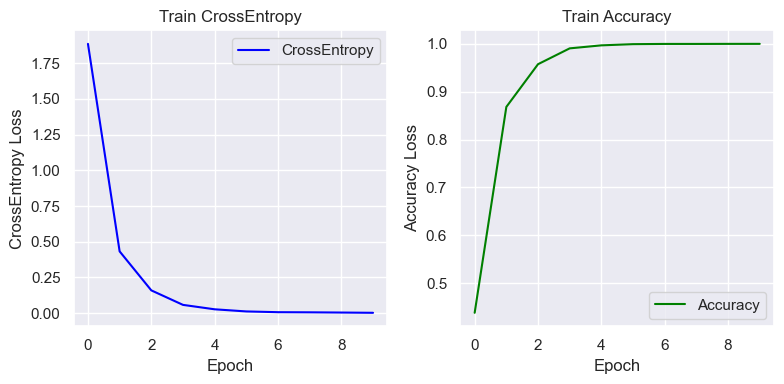

In [6]:
from CNNClassifier import CNNClassifier

epochs = 10

model = CNNClassifier(output_size=25).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

cross_entropy_values = []
accuracy_values = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_title('Train CrossEntropy')
ax2.set_title('Train Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('CrossEntropy Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy Loss')

for epoch in range(epochs):
    cross_en_avg = 0
    accuracy_avg = 0
    batch_count = 0
    
    model.train()
    train_progress = tqdm(train_loader, leave=True)
    
    for inputs, targets in train_progress:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
        
        loss.backward()
        optimizer.step()
        
        _, predicted_classes = torch.max(predictions, 1)
        correct_predictions = (predicted_classes == targets).sum().item()
        accuracy = correct_predictions / targets.size(0)
        
        batch_count += 1
        cross_en_avg = (1 / batch_count) * loss.item() + (1 - 1 / batch_count) * cross_en_avg
        accuracy_avg = (1 / batch_count) * accuracy + (1 - 1 / batch_count) * accuracy_avg
        
        train_progress.set_description(f'Epoch [{epoch + 1}/{epochs}] ' + \
            f'CrossEntropy: {cross_en_avg:.3f}, Accuracy: {accuracy_avg:.3f}')
    
    cross_entropy_values.append(cross_en_avg)
    accuracy_values.append(accuracy_avg)

torch.save(model.state_dict(), os.path.join(weights_dir, 'cnn_classifier_weights.pth'))

ax1.plot(range(epochs), cross_entropy_values, color='blue', label='CrossEntropy')
ax2.plot(range(epochs), accuracy_values, color='green', label='Accuracy')
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

#### Тестирование модели 2: Сверточная нейросеть

In [7]:
import torch
import numpy as np

correct_predictions = 0
total_test_loss = 0

model.eval()

sample_images = []
sample_probs = []

random_indices = np.random.choice(test_batch_size, 2, replace=False)

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
        total_test_loss += loss.item()
        
        predicted_classes = torch.argmax(predictions, dim=1)
        correct_predictions += (predicted_classes == targets).sum().item()
        
        if len(sample_images) < 2:
            for idx in random_indices:
                global_idx = i * inputs.shape[0] + idx
                if global_idx < len(test_loader.dataset):
                    sample_images.append(inputs[idx].cpu().numpy())
                    sample_probs.append(torch.softmax(predictions[idx], dim=0).cpu().numpy())

accuracy = correct_predictions / len(test_loader.dataset)
average_test_loss = total_test_loss / len(test_loader)

print(f'Test CrossEntropy Loss: {average_test_loss:.3f}')
print(f'Test Accuracy: {accuracy:.3f}')


Test CrossEntropy Loss: 0.506
Test Accuracy: 0.898


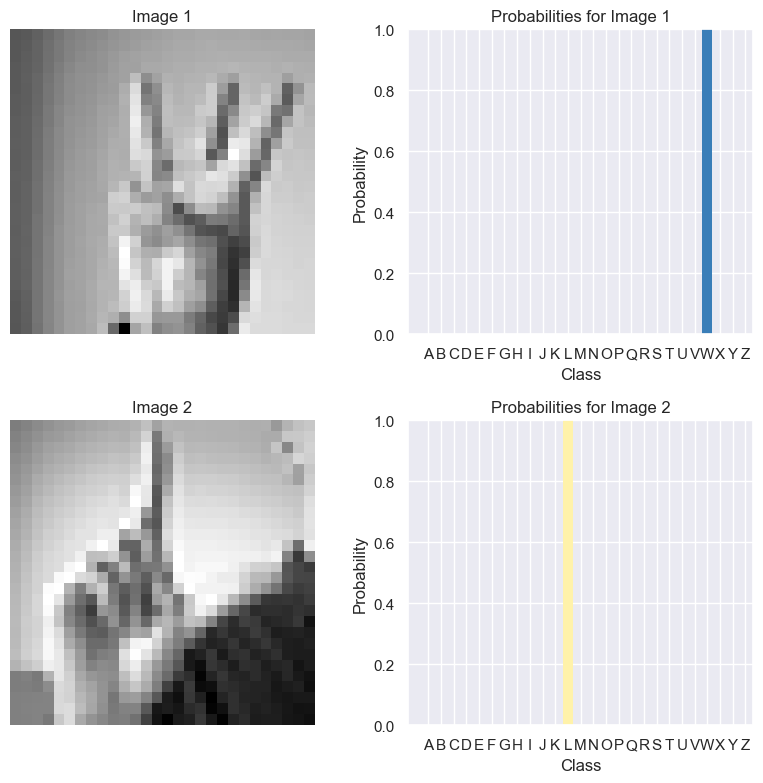

In [8]:
class_labels = list(string.ascii_uppercase)[:26]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
cmap = plt.get_cmap("Spectral")

for i in range(2):
    ax = axes[i, 0]
    ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Image {i+1}')
    ax = axes[i, 1]
    
    bars = ax.bar(range(25), sample_probs[i], color=cmap(np.linspace(0, 1, 25)), edgecolor='none')
    
    ax.set_ylim(0, 1)
    ax.set_title(f'Probabilities for Image {i+1}')
    ax.set_xticks(range(26))
    ax.set_xticklabels(class_labels)
    ax.set_xlabel('Class')
    ax.set_ylabel('Probability')

plt.tight_layout()
plt.show()